[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aarondomenzain/tracking-softmatter-aarond/blob/tracking-softmatter-aarond-dev/tutorial/detection/detection_spheres.ipynb)

# Particle Tracking Tutorial: Particle Detection

In this tutorial, we compare different methods for detecting particles in microscopy images, using both simulated and experimental data. The analysis is carried out using a range of Python packages, including NumPy, SciPy, Matplotlib, scikit-image, PyTorch, DeepTrack, and Deeplay.

### 1. Import the Required Libraries and Load Utility Functions

Uncomment the next cell if running on Google Colab/Kaggle.

In [1]:
#!pip install deeptrack deeplay trackpy -q

Import required libraries.

In [2]:
# Standard libraries.
#import math  # Mathematical operations.
import os  # Operating system dependent functionality.
import random  # Generate random numbers.
import sys  # System-specific parameters and functions.

# External libraries.
#import cv2  # OpenCV (Computer Vision).
import deeptrack as dt  # DeepTrack.
import deeplay as dl  # Deeplay.
from deeptrack.extras.radialcenter import radialcenter as rc 
from itertools import cycle # Iterate over a list.
import imageio  # Creates images/video from data.
import matplotlib # Plotting package
import matplotlib.pyplot as plt  # Plotting package with additional funcitons.
import numpy as np  # Scientific computing using arrays.
import scipy  # Optimized for linear algebra, signal processing.
import skimage  # Image analysis (scikit).
import torch  # PyTorch library for neural network applications.
import trackpy as tp  # Particle tracking package (Crocker & Grier method).

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


Load a set of custom functions defined specifically for this notebook from the `utils.py` file. For detailed documentation of each function, refer to the comments and docstrings within utils.py.

In [3]:
# Load functions and utilities for dataset generation and visualization.
# Sys append a folder to the path.
sys.path.append("..")

# Import all the functions contained in the utilities file utils.py.
import utils

### 2. Visualize an Experimental Image
Load a `.tif` image from the `images/` folder and display it using scikit-image.

Selected file: images/JT008_AFM_15.tif


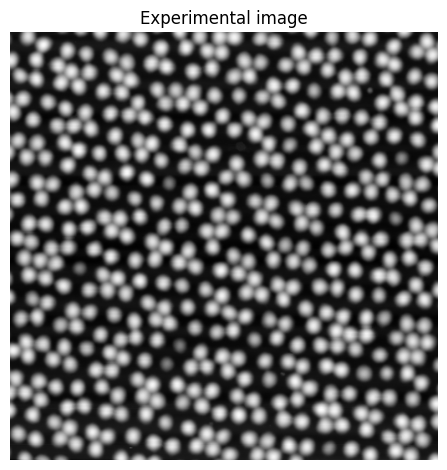

Size of imported image in pixels: (512, 512)


In [4]:
# Define the folder and image file name.
image_folder = "images"
image_file_name = "JT008_AFM_15.tif"

# Construct the full path.
image_path = os.path.join(image_folder, image_file_name)

# Create an instance of the loaded file using SciKit.
image = skimage.io.imread(image_path)

# Crop the image to a square.
#image = image[:1024, :1024]
image = image[:640, :640]

# Print the name of the selected file.
print("Selected file:", image_path)

# Open a figure instance.
plt.figure()

# Plot the image in grayscale.
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Experimental image")
plt.tight_layout()
plt.show()

# Print the image size in pixels.
print(f"Size of imported image in pixels: {image.shape}")

Manually select and display a single particle by specifying its centroid coordinates (x,y) and a box width.

**Note:** Images in NumPy are indexed as `(row, column)`, which corresponds to (y, x) in Cartesian coordinates.

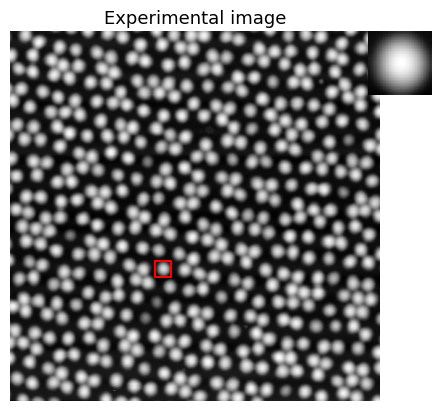

In [37]:
# # Window size to zoom in an individual particle.
width = 22

# Coordinates of the center of the particle.
x_center = 212
y_center = 329

# Calculate top-left corner of the crop.
x = x_center - width // 2
y = y_center - width // 2

# Select a crop as a subset of the entire image.
crop = image[y:y + width, x:x + width]  # row (y), column (x)

# Initialize figure instance.
fig = plt.figure()

# Draw a red rectangle around the crop.
fig.add_subplot(111)
plt.imshow(image, cmap='gray')
plt.title("Experimental image", size=13)
plt.plot([x, x, x+width, x+width, x],[y, y+width, y+width, y, y], 'r-')
plt.axis('off')

# Plot the rectangle on the top right corner.
fig.add_subplot(555)
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.show()

### 3. Simulate Realistic Images with DeepTrack
DeepTrack allows you to simulate physically realistic microscopy images, providing precise control over imaging parameters and particle properties. These simulations include ground-truth data, making them ideal for benchmarking classical and AI-based tracking methods, as well as for training neural networks in a controlled environment.

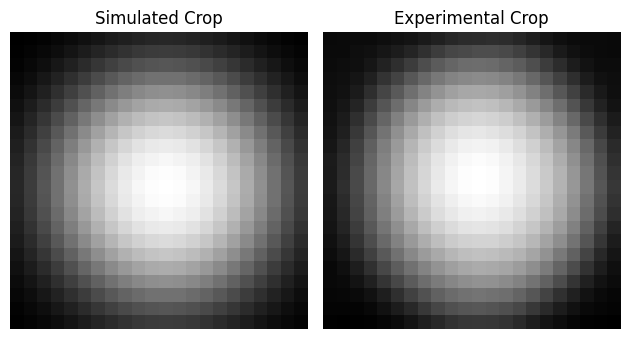

In [ ]:
# Same as when selecting a single object.
image_size = width  

# Size of a pixel in nanometers in the output image.
pixel_size = 100 # In nm.

# Radius of the particle.
particle_radius = 950 # In nm.

# Define central spherical scatterer.
sphere = dt.Sphere(
    position=0.5 * np.array([image_size, image_size]),
    z=-100 * dt.units.nm, # Particle out of focus.
    radius= particle_radius * dt.units.nm,  # Radius in nanometers.
    intensity= 3.2E5,  # Field magnitude squared.
)

# Simulate the properties of the fluorescence microscope.
optics = dt.Fluorescence(
    NA=0.4,  # Numerical aperture.
    wavelength=638 * dt.units.nm, 
    refractive_index_medium=1.33, 
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size * dt.units.nm, # Camera resolution or effective resolution.
    )

# Apply transformations to crop.
sim_crop = (
    optics(sphere)
    # >> dt.NormalizeMinMax(0.0, 1.0)
    )

# Turn the crop into a NumPy array.
simulated_crop = np.squeeze(sim_crop())

# Plot the simulated and experimental crops.
fig, axes = plt.subplots(1, 2)

# Simulated crop.
plot = axes[0].imshow(simulated_crop, cmap="gray")
axes[0].axis("off")
axes[0].set_title("Simulated Crop")


# Experimental crop.
axes[1].imshow(crop, cmap="gray")  
axes[1].axis("off")
axes[1].set_title("Experimental Crop")

# Adjust layout and show plot.
plt.tight_layout()
plt.show()

We extract and visualize the raw intensity profiles along the central horizontal line of both the simulated and experimental crops. This comparison helps evaluate how well the simulation reproduces the intensity distribution observed in real microscopy images.

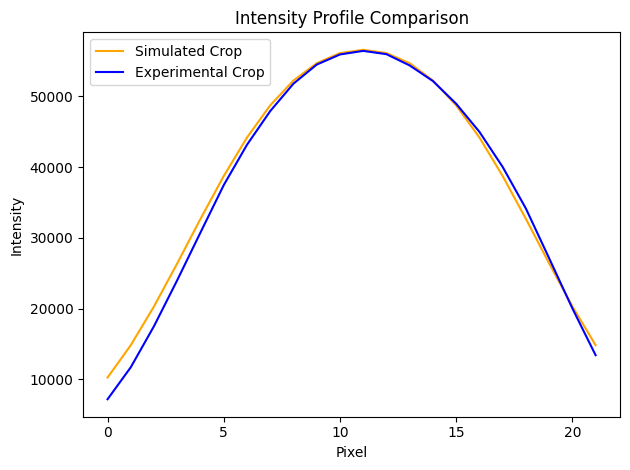

In [41]:
# Calculate and display the raw intensity profile of the simulated experimental crops.
simulated_crop_intensity = simulated_crop[image_size // 2, :]
experimental_crop_intensity = crop[image_size // 2, :]
fig, ax = plt.subplots()
ax.plot(simulated_crop_intensity, label="Simulated Crop", color="orange")
ax.plot(experimental_crop_intensity, label="Experimental Crop", color="blue")
ax.set_xlabel("Pixel")
ax.set_ylabel("Intensity")
ax.set_title("Intensity Profile Comparison")
ax.legend()
plt.tight_layout()
plt.show()

### Generate a Simulated Image to Test Detection Methods
We simulate an image containing non-overlapping spherical particles. First, we generate their coordinates—these serve as the ground-truth positions. Then, using DeepTrack, we render optically realistic particles at these positions to create a physically plausible microscopy image.

In [ ]:
# Parameters of the simulation.
image_size = 256
N_particles = 128
particle_radius = 900  # Particle radius in nm.
particle_radius_px = particle_radius / pixel_size # In pixels

# Dictionaries for shell and core properties. Dimensions are set with lambda
# functions to introduce variety to the dataset.
sphere_properties = {
    "radius": lambda: np.random.uniform(0.85, 1.05) * particle_radius * dt.units.nm,
    "intensity": lambda: np.random.uniform(0.7, 1.3) * 3.2E5,
    }

# Set the optical properties of the microscope.  
optics_properties = dt.Fluorescence(
    NA=0.4,  # Numerical aperture.
    wavelength=638 * dt.units.nm, 
    refractive_index_medium=1.33, 
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size * dt.units.nm, # Camera resolution or effective resolution.
    )

# Generate ground truth positions.
gt_pos = utils.generate_centroids(
    num_particles=N_particles,
    image_size=image_size,
    particle_radius=particle_radius, 
    )

# Simulate image.
simulated_image = utils.transform_to_video(
    gt_pos,
    image_size=image_size,
    core_particle_props=sphere_properties,
    optics_props=optics_properties,
    )

# Generate the ground truth as Gaussian clouds centered at the position of the
# spheres. The standard deviation of the Gaussians are set to be proportional 
# to the radii of the corresponding spherical particles.
ground_truth_cloud_size = particle_radius / 3

# Generate ground truth map using the positions, radii and intensities of the 
# particles.
simulated_map = utils.create_ground_truth_map(
    gt_pos, 
    image_size=image_size, 
    sigma=ground_truth_cloud_size, 
    )

Visualize the simulated image and the corresponding ground truth map. Each particle has an associated ground truth cloud with a Gaussian profile, whose standard deviation is proportional to the radius of the particle.

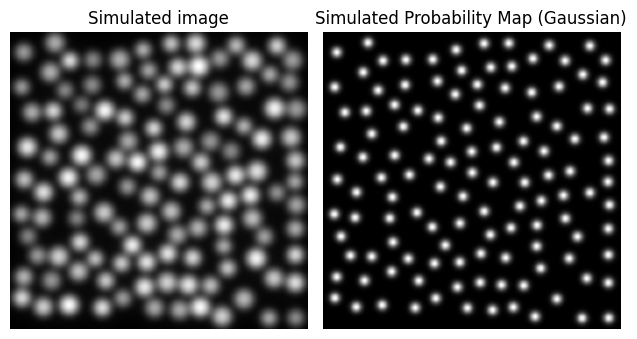

In [43]:
# Create a subfigure instance to plot the image and the probability map.
fig, ax = plt.subplots(1, 2)

# Instance for the simulated experimental image. 
img1 = ax[0].imshow(simulated_image, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Simulated image")  

# Instance for the probability map.
img2 = ax[1].imshow(simulated_map, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Simulated Probability Map (Gaussian)") 

# Adjust layout to avoid overlap.
plt.tight_layout()

# Show the plot.
plt.show()

### 4. Detection and analysis

After generating a realistic simulation of the experiment, we can implement, evaluate and compare different detection algorithms. This is enabled by the fact that the ground truth —i.e., the actual particle positions— is known, allowing for a direct and precise comparison of the detection accuracy.

The following detection methods will be implemented and evaluated with respect to the ground truth:

1. Thresholding (using scikit regionprops)
2. Crocker and Grier (using trackpy)
3. UNet convolutional neural network (using DeepTrack)
4. Lodestar.

## Method 1: 

In a grayscale image, each pixel has an intensity value that, when normalized, ranges from 0 to 1. Values close to 1 represent the highest signal intensities, typically corresponding to particles, while values near 0 correspond to the background—especially in high signal-to-noise ratio (SNR) images.

A simple method to detect particles is to apply **intensity thresholding**, converting the image into a binary mask. Pixels with intensities above a threshold are set to 1 (foreground), and others to 0 (background).

A robust way to choose this threshold is to use the **intensity quantile**. For example, setting the threshold at the 90th percentile selects the brightest 10% of pixels, which often correspond to particles. This method is more reliable than using the image mean and standard deviation, which can be biased by background-dominated images.

**Note:** In cases where particles are darker than the background (e.g., absorption or negative stain imaging), the threshold should be applied to the lower tail of the intensity distribution instead.

In [ ]:
# Apply a Gaussian filter to the image to smooth out noise.
filtered_image_sim = scipy.ndimage.gaussian_filter(simulated_image, sigma=1.0)

# Flatten the filtered image for thresholding.
flattened_image_filtered = filtered_image_sim.flatten()

# Define the quantile level (e.g., 90% selects the top 10% brightest pixels).
quantile_level = 0.85

# Compute the threshold as the intensity value at the given quantile.
intensity_threshold = np.quantile(flattened_image_filtered, quantile_level)

print(f"Intensity threshold (quantile={quantile_level*100:.0f}%): {intensity_threshold}")

Intensity threshold (quantile=85%): 0.5126321697287273


Plot the intensity histogram of the simulated image, both before and after Gaussian filtering.

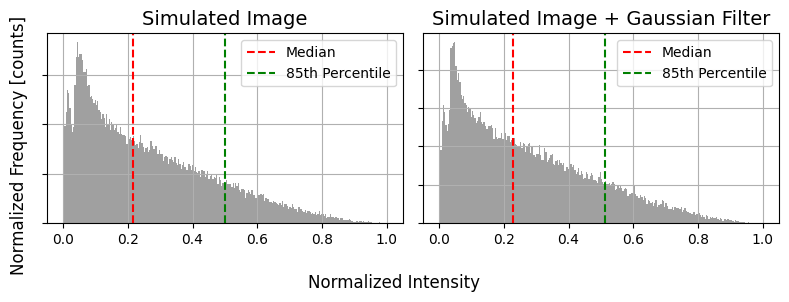

In [74]:
# Compute statistics
median_intensity_simulated = np.median(flattened_image_simulated)
quantile_threshold_simulated = np.quantile(flattened_image_simulated, quantile_level)

median_intensity_filtered = np.median(flattened_image_filtered)
quantile_threshold_filtered = np.quantile(flattened_image_filtered, quantile_level)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Histogram for simulated image
axes[0].hist(flattened_image_simulated, bins=256, range=(0, 1), color='gray', alpha=0.75, density=True)
axes[0].axvline(median_intensity_simulated, color='red', linestyle='dashed', linewidth=1.5, label="Median")
axes[0].axvline(quantile_threshold_simulated, color='green', linestyle='dashed', linewidth=1.5, label=f"{int(quantile_level*100)}th Percentile")
axes[0].set_title("Simulated Image", fontsize=14)
axes[0].set_yticklabels([])  # Remove y labels
axes[0].legend()
axes[0].grid(True)

# Histogram for filtered image
axes[1].hist(flattened_image_filtered, bins=256, range=(0, 1), color='gray', alpha=0.75)
axes[1].axvline(median_intensity_filtered, color='red', linestyle='dashed', linewidth=1.5, label="Median")
axes[1].axvline(quantile_threshold_filtered, color='green', linestyle='dashed', linewidth=1.5, label=f"{int(quantile_level*100)}th Percentile")
axes[1].set_title("Simulated Image + Gaussian Filter", fontsize=14)
axes[1].set_yticklabels([])  # Remove y labels
axes[1].legend()
axes[1].grid(True)

# Set common x and y labels
fig.supxlabel("Normalized Intensity", fontsize=12)
fig.supylabel("Normalized Frequency [counts]", fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

### Threshold the Image
Apply the threshold to generate a binary mask, then display it together with the original image for visual validation.

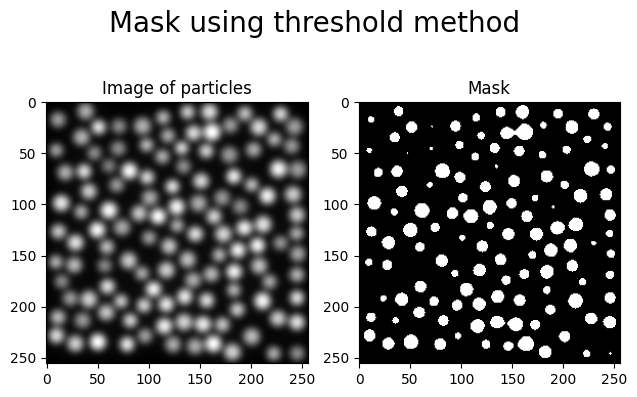

In [75]:
# Create the binary mask by applying the threshold.
simulated_mask = simulated_image > intensity_threshold

# Ensure the mask is a 2D array.
simulated_mask = np.squeeze(simulated_mask)

# Plot the image with the calculated mask.
utils.plot_image_mask_ground_truth_map(
    image=simulated_image, 
    mask=simulated_mask, 
    title="Mask using threshold method",
)

### Determine and Plot the Centroids from the Mask 
Extract centroids from the mask using Scikit.

In [76]:
# Use the function to extract positions from mask.
detections_M1 = utils.mask_to_positions(simulated_mask)

Plot the extracted centroids over the image.

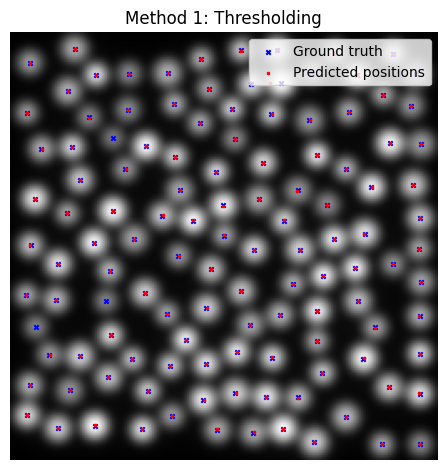

In [77]:
# Use the plotting function to compare the detection with the ground truth.
utils.plot_predicted_positions(image=simulated_image, 
                         predicted_positions=detections_M1, 
                         ground_truth_positions=gt_pos, 
                         title="Method 1: Thresholding"
                         )

### Evaluate performance the Thresholding Method
Apply a function that calculates evaluation metrics and print them. True Positives (TP), False Positives (FP), False Negatives (FN), F1 score (F1) and Mean Square Error (MSE).

In [78]:
# Evaluation metrics can be retrieved if returned outputs are asigned to a variable:
# TP, FP, FN, F1, RMSE = utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius).

utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius);

True Positives: 119/123
False Positives: 0
False Negatives: 4
F1 Score: 0.9835
RMSE: 0.4517


#### Bonus: Refine Localization Using Radial Symmetry
The utility function `locate_particle_centers()` refines particle positions by leveraging the radial symmetry around each initially detected center. It focuses on regions of interest surrounding these centers and improves localization accuracy—especially for spherical particles, where the symmetry assumption holds. This approach helps achieve subpixel precision in position estimates.

Use radial symmetry refinement on top of the thresholding method to achieve more accurate centroid positions.

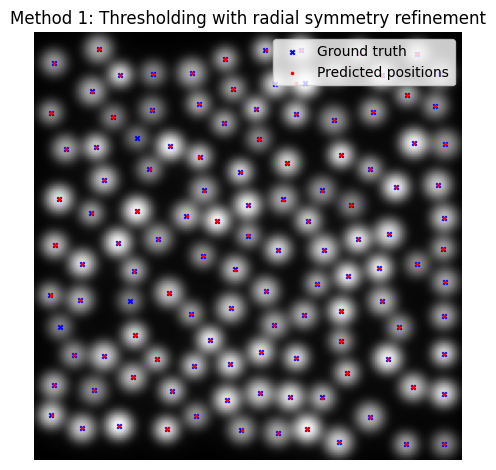

True Positives: 119/123
False Positives: 0
False Negatives: 4
F1 Score: 0.9835
RMSE: 0.3815


In [79]:
# Estimate the location of the centroid of a masked particle optical signal.
detections_M1_ref = utils.locate_particle_centers(
    detections_M1, 
    simulated_image, 
    estimated_radius=particle_radius
)

# Use the plotting function to compare the detection with the ground truth.
utils.plot_predicted_positions(
    image=simulated_image, 
    predicted_positions=detections_M1_ref, 
    ground_truth_positions=gt_pos, 
    title="Method 1: Thresholding with radial symmetry refinement"
)

# Evaluate the performance.
utils.evaluate_locs(detections_M1_ref, gt_pos, distance_th=particle_radius);

### Apply the Threshold Method to Experimental Data

No ground truth positions were passed


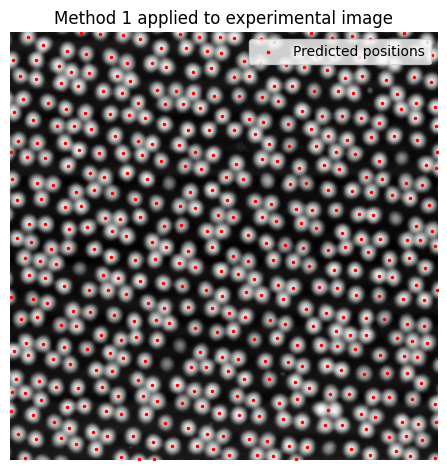

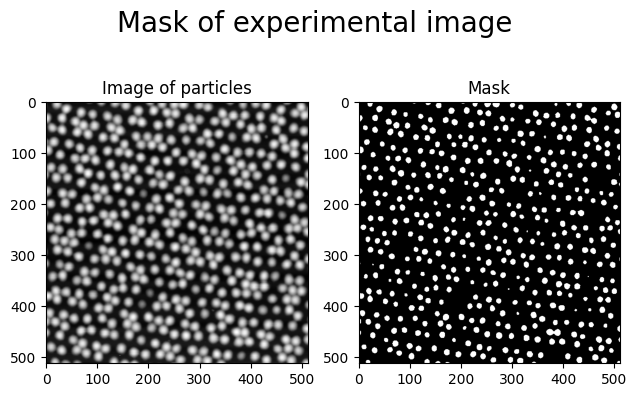

Found 457 detections.


In [ ]:
# # Normalize the experimental image to have (0,1) intensity values.
# image = utils.normalize_min_max(image)

quantile_level = 0.85  # 85% quantile level for thresholding.

# Intensity threshold for the experimental image.
quantile_threshold_exp = np.quantile(image, quantile_level)

# Create the binary mask by applying the threshold.
mask_exp = image > quantile_threshold_exp

# Get predicted positions from the mask.
detections_M1_exp = utils.mask_to_positions(mask_exp)

detections_M1_exp_ref = utils.locate_particle_centers(
    detections_M1_exp,
    image,
    estimated_radius=particle_radius,
)

utils.plot_predicted_positions(
    image=image,
    predicted_positions=detections_M1_exp,
    title="Method 1 applied to experimental image",
)

# Plot the experimental image and the mask.
utils.plot_image_mask_ground_truth_map(
    image=image, 
    mask=mask_exp, 
    title="Mask of experimental image",
)

# Print the number of detections.
print(f"Found {len(detections_M1_exp[:,1])} detections.")

## Method 2: Crocker and Grier (using Trackpy)
Trackpy provides a built-in implementation of the Crocker and Grier particle detection method. The only parameter you need to set is the estimated particle diameter. Make sure it's an odd number.

### Estimate Particle Diameter from the Experimental Image
Click on both edges of a particle in the experimental image to estimate its diameter. Since particle sizes may vary, consider this an initial approximation that can be refined later based on detection performance.

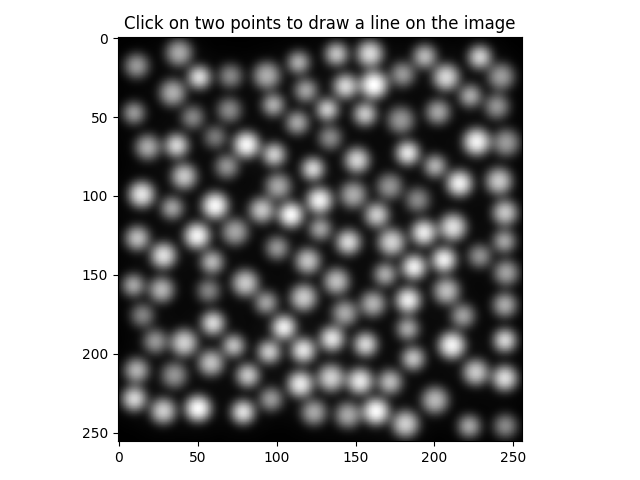

In [82]:
# Set the matplotlib interactive backend .
%matplotlib widget
utils.interactive_ruler(simulated_image)

### Apply the Crocker and Grier Method
Use `trackpy.locate` to detect particles in the image. The function returns a DataFrame with the detected positions and feature properties.

Extract the (x,y) coordinates and compare the predicted positions with the ground truth to evaluate performance.

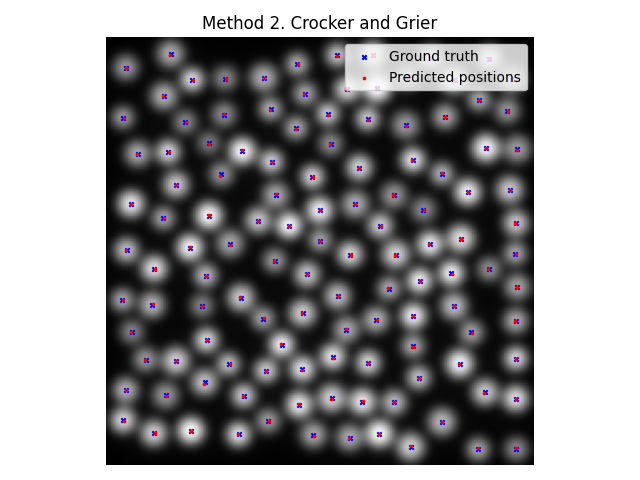

True Positives: 123/123
False Positives: 0
False Negatives: 0
F1 Score: 1.0000
RMSE: 0.6252


In [83]:
# Estimate and tune the diameter of particles in pixels, ensuring it is an
# odd number. Adjust if necessary.
estimated_diameter = 15

# Use the locate built-in function from TrackPy.
    # Output is type DataFrame([x, y, mass, size, ecc, signal, raw_mass]).
localizations_dataframe = tp.locate(
    simulated_image, 
    diameter=estimated_diameter,
    noise_size=4, # Setting for denoising image.
    )

# Extract the predicted positions from DataFrame["x","y"] into a NumPy array.
detections_M2 = np.array(localizations_dataframe)[:,:2]

# Plot the prediction and the ground truth.
utils.plot_predicted_positions(
    image=simulated_image,
    predicted_positions=detections_M2,
    ground_truth_positions=gt_pos,
    title="Method 2. Crocker and Grier",
)

# Evaluate the performance of tp.locate.
utils.evaluate_locs(
    detections_M2,
    gt_pos,
    distance_th=particle_radius,
);

### Apply the Crocker and Grier Method to Experimental Data

Intractively estimate particle diameter.

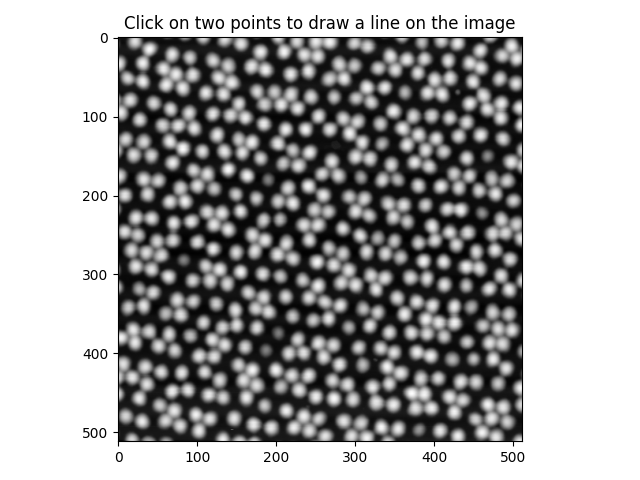

In [84]:
# Set the matplotlib interactive backend .
%matplotlib widget
utils.interactive_ruler(image)

Detect particles in the image and display the results.

No ground truth positions were passed


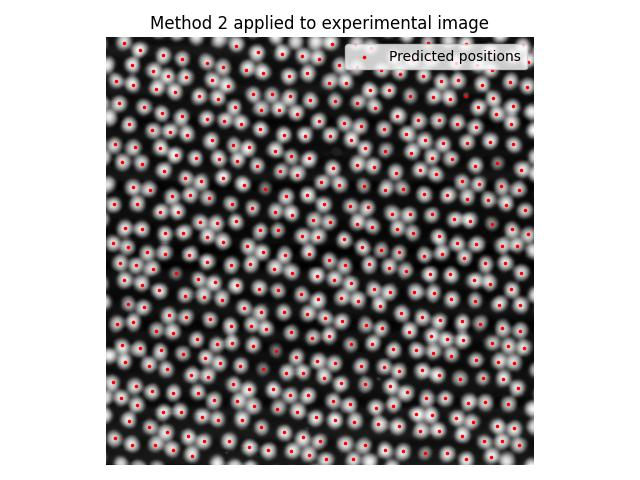

Found 435 detections.


In [ ]:
# Adjust the estimated diameter if necessary. 
estimated_diameter = 15

# Use Trackpy.locate to experimental data file 'image'.
localizations_dataframe_exp = tp.locate(
    image, 
    diameter=estimated_diameter, 
    invert=False,
    preprocess=True,
)

# Extract the predicted positions from DataFrame["x","y"] into a NumPy array.
detections_M2_exp = np.array(localizations_dataframe_exp)[:,:2]

# Plot the experimental image with predicted positions overlaid.
utils.plot_predicted_positions(
    image=image,
    predicted_positions=detections_M2_exp,
    title="Method 2 applied to experimental image",
)

print(f"Found {len(detections_M2_exp[:,1])} detections.")

## Method 3: UNet

U-Net is a convolutional neural network (CNN) widely used for image segmentation tasks. It performs pixel-wise classification, enabling precise separation between background and objects of interest—ranging from simple particles to complex cells or anatomical structures, depending on the training data.

The name "U-Net" refers to its characteristic U-shaped architecture, which consists of a symmetric encoder–decoder structure. The encoder (or downsampling path) captures contextual information by reducing spatial resolution, while the decoder (upsampling path) restores spatial detail. Skip connections between corresponding levels of the encoder and decoder help preserve fine-grained features, improving segmentation accuracy—especially for small or faint objects.

### Create a training dataset
Simulated images of particles are generated using DeepTrack, along with their corresponding probability maps, which serve as the ground truth.

Load a dataset if available, otherwise, generate it according to the size of the sample and the image size defined by the user.

In [ ]:
# Number of samples, image size, and particles.
num_samples = 128
image_size = 64
max_num_particles = 10
force_simulation = True  # Flag to force simulation even if data exists.

# # Radius and intensity set to zero means no shell.
# shell_particle_properties = {
#     "radius": 0 * dt.units.nm,
#     "intensity": 0,
# }

# Simulate the properties of the fluorescence microscope.
optics_properties = dt.Fluorescence(
    NA=0.4,  # Numerical aperture.
    wavelength=638 * dt.units.nm, 
    refractive_index_medium=1.33, 
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size * dt.units.nm, # Camera resolution or effective resolution.
    )

# Create path to store training dataset.
folder_name = "UNet"
training_dataset_filename = "UNet_training_dataset_spheres.npz"
training_dataset_folder = folder_name + "/" + "training_data"
training_dataset_filepath = (
    training_dataset_folder + "/" + training_dataset_filename
    )

# Create the enclosing directory if not existent already.
if not os.path.exists(training_dataset_folder):
    os.makedirs(training_dataset_folder, exist_ok=True)



# Try to load preexisting data, if not available or forced, raise the
# exception error to generate new data.
try:
    if force_simulation: 
        # Raise the exception error if simulation is forced.
        raise FileNotFoundError("Forced simulation by user request.")
    
    if not os.path.isfile(training_dataset_filepath):
        # If file is not found, start training.    
        raise FileNotFoundError(
            "Training dataset file not found. Starting simulation."
        )
    
    # Load existing data
    data = np.load(training_dataset_filepath)
    print(f"Loaded file: {training_dataset_filepath}")
    images = data['images']
    maps = data['maps']
    Nsamples = len(images)
        
# Handle the case of either file not found or forced training.
except FileNotFoundError:
    
    # Perform simulation if file not found or forced.
    images, maps = utils.generate_particle_dataset(
        num_samples,
        image_size,
        max_num_particles,
        sphere_properties,
        optics_properties=optics_properties,
        )
    
    # Save the simulated training dataset.
    np.savez(training_dataset_filepath, images=images, maps=maps)
    print(f"Training dataset saved in: {training_dataset_filepath}.")

Check dimensions of training data. The format to train a U-Net model with Deeplay should be (N,X,Y,C), where:\
\
N: Number of samples (simulated images).\
X: Intensity in the X position.\
Y: Intensity in the Y position.\
C: Color channel (1 for grayscale).

In [ ]:
print(f"Image dimensions: {images.shape}")
print(f"Maps dimensions: {maps.shape}")

### Visualize the simulated training dataset


In [ ]:
# Select an image and its corresponding probability maps and mask to show.
selected_image_index = np.random.randint(0, len(images))

# Extract the image and probability map from 4D arrays.
selected_image = np.squeeze(images[selected_image_index])
simulated_probability_map = np.squeeze(maps[selected_image_index])

# # Plot the image as the first subplot.
utils.plot_image_mask_ground_truth_map(
    image=selected_image,
    ground_truth_map=simulated_probability_map,
    title=f"Training dataset element: {selected_image_index + 1}/{len(images)}",
    )

### Define a U-Net model using Deeplay
The input and output channels of the 2D U-Net are equal to 1, since for the moment we are only analyzing one single color channel corresponding to light intensity in grayscale. We want the U-Net model to be able to recognize a probability map of particles from an experimental image. The single-channel output will then be the spatial probability density.

The U-Net architecture need to be deep enough in order to have a good (reduced) representation of the input image. In order to set the number of convolutional layers N, we use the heuristic argument that N layers, provided with a (default) kernel size of 3x3, enables a (3x3)^N window to look for features in an image. Three layers will enable a 27x27 window, suitable to train a detector of particles with diameters up to 27 pixel units.

In [ ]:
# Input and output channels are set to 1, since both images and probability
# maps only have one color channel.
unet = dl.UNet2d(
    in_channels=1, 
    channels=[16, 32, 64], 
    out_channels=1,
)

### Compile the model for the task of regressing the masks from the images

In [ ]:
# A U-Net regressor is defined using a deeplay model. The loss function is Mean
# Squared Error Loss, since the output is a continuous intensity map.
unet_reg = dl.Regressor(
    model=unet, 
    loss=torch.nn.MSELoss(), 
    optimizer=dl.Adam(lr=1e-3),
    ).create()

### Define the training pipeline using Deeptrack to generate the training dataset
The training pipeline is composed of the simulated images and the probability maps, together with instructions of value normalization and a selector of images, all of which are instances of Deeplay.

In [ ]:
# Image selector with a random picker. This is performed in order to properly 
# link an element in maps array with its corresponding element in images 
# array.
selector = dt.Lambda(
    lambda i: lambda x: x[i], i=lambda l: np.random.randint(l), l=len(images)
    )

# Apply augmentations of added Gaussian noise only to images.
images_augmentations = (
    dt.Value(images)
    >> dt.Gaussian(0.0, 0.015)
    >> dt.NormalizeMinMax(
        lambda: np.random.uniform(0.0, 0.1), 
        lambda: np.random.uniform(0.9, 1.0)
        )
    )

# Apply normalization to ground truth map.
maps = dt.Value(maps) >> dt.NormalizeMinMax(0.0, 1.0)

# Training pipeline consists of two paired lists: images and maps. 
# Images are augmented and normalized, while maps are only normalized.
# The selector randomly selects an image and its corresponding ground truth map.
# The pipeline is then passed to the deeplay model.
pipeline = (images_augmentations & maps) >> selector

# Create the training dataset instance in PyTorch
train_dataset = dt.pytorch.Dataset(pipeline, length=256)

Check one augmented crop at random

In [ ]:
# Sanity check
sanity_check_pipeline_augmentation = np.squeeze(pipeline.update().resolve())
sanity_check_image_augmentation = sanity_check_pipeline_augmentation[0]
sanity_check_map_augmentation = sanity_check_pipeline_augmentation[1]

# # Plot the image as the first subplot
utils.plot_image_mask_ground_truth_map(
    image=sanity_check_image_augmentation,
    ground_truth_map=sanity_check_map_augmentation,
    title=f"Random augmentation from training pipeline",
    )

### Train the U-Net model

In [ ]:
from torch.utils.data import DataLoader

# Create a DataLoader for training.
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True,
)

# Initialize UNet trainer with automatic accelerator (e.g., CUDA if available).
unet_trainer = dl.Trainer(max_epochs=64, accelerator="auto")

Tries to load weights if existent. Else, start training and save weights.

In [ ]:
# Force training if desired.
force_training = True

# Define the file paths for the model weights.
unet_path = "UNet_model_spheres"
unet_reg_path = "UNet_reg_spheres"

# Define the paths to store files inside the U-Net folder.
unet_path =  folder_name + "/" + unet_path
unet_reg_path = folder_name + "/" + unet_reg_path

# Check if both weight files exist in order to load them.
if os.path.exists(unet_path) and os.path.exists(unet_reg_path):
    
    # Load the dictionaries
    unet.load_state_dict(torch.load(unet_path, weights_only=True))
    unet_reg.load_state_dict(torch.load(unet_reg_path, weights_only=True))
    print(f"Model weights already existent. \
        Loaded successfully from working directory.")

# Starts training if forced or if unet weights are not found in the path.
if force_training or not os.path.exists(unet_path):
    
    # Create the enclosing directory if not existent already.
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    
    # Start training with the regressor and the data loader.
    unet_trainer.fit(unet_reg, train_loader)
    
    # Save the pre-trained weights of the U-Net model as Python dictionaries.
    torch.save(unet.state_dict(), unet_path)
    torch.save(unet_reg.state_dict(), unet_reg_path)

### Apply the trained U-Net to the simulated image
Select a new image that has not been used for the training to infere the probability map, based on the learning acquired by the U-Net.

In [ ]:
# Select an image to apply the learning by the U-Net.
image_of_particles = np.array(simulated_image).astype(np.float32)
print(f" Shape of selected image: {image_of_particles.shape} ")

# Normalize intensity of image to (0,1).
image_of_particles = utils.normalize_min_max(image_of_particles)

# Create a new axis and rearrange to (N,X,Y,C) format.
# In this case, it should be (1, 1, 256, 256).
image_of_particles = np.expand_dims(image_of_particles, axis=0)
image_of_particles = image_of_particles.transpose(0, 3, 1, 2)
print(f" Shape of selected image after transposing to match the (N, C, X, Y): {image_of_particles.shape} ")

Convert the selected image to a PyTorch tensor to infer the probability map of the particles using the learning of the trained U-Net

In [ ]:
# Convert the image to analyze into a PyTorch tensor.
image_of_particles_tensor = torch.from_numpy(image_of_particles)

# Apply the UNet to the loaded image.
pred_maps_tensor = unet_reg(image_of_particles_tensor)

# Convert to NumPy array.
pred_maps_array = pred_maps_tensor[0,0,:,:].detach().numpy()

# Normalize intensity.
pred_maps_array = utils.normalize_min_max(pred_maps_array)

Apply the mask method to the predicted probability map

In [ ]:
# Apply thresholding to the predicted ground truth map.
pred_mask_unet = pred_maps_array > 0.25

# Convert the masked ground truth map to positions.
detections_unet = utils.mask_to_positions(pred_mask_unet)

# Show the predicted posiions overlaid with the ground truth on the simulated
# image.
utils.plot_predicted_positions(
    image=simulated_image,
    predicted_positions=detections_unet, 
    ground_truth_positions=gt_pos,
    title="Prediction from U-Net"
    )

# Measure the performance.
utils.evaluate_locs(detections_unet, gt_pos, distance_th=particle_radius_px)

#Plot the predicted ground truth map and its masked version.
utils.plot_image_mask_ground_truth_map(
    mask=pred_mask_unet,
    ground_truth_map=pred_maps_array,
    title="U-Net prediction on simulated data"
)

### Apply the trained U-Net to the experimental image


In [ ]:
# Normalize intensity of image to (0,1).
image_of_particles_exp = utils.normalize_min_max(image)

# Reshape the array to match the (N, C, X, Y) format.
image_of_particles_exp = image_of_particles_exp[np.newaxis, np.newaxis, ...]

# Ensure that the image is a numpy array.
image_of_particles_exp = np.array(image_of_particles_exp).astype(np.float32) 

# Convert the image to analyze into a PyTorch tensor.
image_of_particles_exp_tensor = torch.from_numpy(image_of_particles_exp)

# Apply the UNet to the loaded image.
pred_maps_unet_exp = unet_reg(image_of_particles_exp_tensor)

# Convert the prediction to a NumPy array for easy plotting.
pred_maps_unet_exp_array = pred_maps_unet_exp[0, 0, :, :].detach().numpy()

# Normalize intensity to (0,1).
pred_maps_unet_exp_array = utils.normalize_min_max(pred_maps_unet_exp_array)

# Calculate a mask from the ground truth map with thresholding method.
pred_mask_unet_exp = pred_maps_unet_exp_array > 0.2

# Extract the positions from the mask.
detections_unet_exp = utils.mask_to_positions(pred_mask_unet_exp)

# Plot the experimental image with the positions predicted by U-Net.
utils.plot_predicted_positions(image=image, 
                         predicted_positions=detections_unet_exp,
                         title="Positions predicted by U-Net. Experimental image",
                         )

#Plot the predicted ground truth map and its masked version.
utils.plot_image_mask_ground_truth_map(
    mask=pred_mask_unet_exp,
    ground_truth_map=pred_maps_unet_exp_array,
    title="U-Net prediction on experimental image",
    )

## Method 4: LodeSTAR
LodeSTAR is a self-supervised object detection method that can be trained using a single input image.\
LodeSTAR will be trained with simulated crops to measure its performance on simulated data and then experimental data. The same idea will be applied to train LodeSTAR with experimental crops.

### Initiate a training pipeline with only one simulated crop.
We can apply augmentations to the same crop to increase the diversity of the dataset.

In [ ]:
# Number of samples, image size, and particles.
num_samples = 128
image_size = 30
max_num_particles = 1
force_simulation = False  # Flag to force simulation even if data exists.

# Create path to store training dataset.
folder_name = "LodeSTAR"
training_dataset_filename = "LodeSTAR_training_dataset_ellipsoids.npz"
training_dataset_folder = folder_name + "/" + "training_data"
training_dataset_filepath = (
    training_dataset_folder + "/" + training_dataset_filename
    )

# Create the enclosing directory if not existent already.
os.makedirs(training_dataset_folder, exist_ok=True)

# Dictionaries for shell and core properties. Dimensions are set with lambda
# functions to introduce a bounded level of randomness to the dataset. 
core_particle_properties = {
    "radius": lambda: np.random.uniform(0.7, 1.2) * particle_radius * dt.units.nm,
    "intensity": lambda: np.random.uniform(0.7, 1.3) * 900,
    }

# Set the optical properties of the microscope.
optics_properties = dt.Fluorescence(
    NA=0.4,  # Numerical aperture
    wavelength=638 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size * dt.units.nm,  # Camera resolution or effective resolution.
    )

# Try to load preexisting simulated data; if not available or forced, raise the
# exception error to generate new data.
try:
    if force_simulation: 
        # Raise the exception error if simulation is forced.
        raise FileNotFoundError("Forced simulation by user request.")
    
    if not os.path.isfile(training_dataset_filepath):
        # If file is not found, start training.    
        raise FileNotFoundError("Training dataset file not found. Starting simulation.")
    
    # Load existing data
    data = np.load(training_dataset_filepath)
    crop_images = data["crop_images"]
    crop_maps = data["crop_maps"]
    Nsamples = len(crop_images)  # Update number of samples.
    print(f"Loaded file: {training_dataset_filepath}")
        
# Handle the case of either file not found or forced training.
except FileNotFoundError:
    
    # Perform simulation if file not found or forced.
    crop_images, crop_maps = utils.generate_particle_dataset(
        num_samples,
        image_size,
        max_num_particles,
        core_particle_properties,
        shell_particle_dict=None,
        optics_properties=optics_properties
        )

    # Save the simulated training dataset.
    np.savez(
        training_dataset_filepath, 
        crop_images=crop_images, 
        crop_maps=crop_maps
        )
    print("Generated and saved new dataset.")
    
    # Plot up to 18 simulated crops.
utils.plot_crops(np.squeeze(crop_images), title="Simulated crops")

In [ ]:
# Define the training pipeline with additional settings, such as multiplication
# of global intensity and Gaussian noise.
selector = dt.Lambda(
    lambda i: lambda x: x[i], i=lambda l: np.random.randint(l), l=len(crop_images)
    )

# Define a training pipeline with augmentations. 
training_pipeline = (
    dt.Value(crop_images)
    #>> dt.Gaussian(0, 0.025)
    >> dt.NormalizeMinMax(
        lambda: np.random.uniform(0.0, 0.1), np.random.uniform(0.8, 1.0)
        )
    >> selector
    )

# Build a training dataset with a pipeline that randomly selects a crop each
# time.
train_dataset = dt.pytorch.Dataset(
    training_pipeline,
    length=256,
    )

# Dataloader contains the randomized training dataset and additional settings.
dataloader = dl.DataLoader(
    train_dataset,
    batch_size=8,
    )

# We can check one of the elements in the training pipeline with augmentations.
sanity_check_crop = training_pipeline.update().resolve()

plt.figure()
plt.imshow(np.squeeze(sanity_check_crop), cmap="gray", aspect="equal")
plt.title("Random crop from training pipeline")
plt.axis("off")
plt.show()

### Initiate the LodeSTAR model and the trainer

In [ ]:
#  Initialize the model.
lodestar = dl.LodeSTAR(
    n_transforms=4, 
    optimizer=dl.Adam(lr=2e-4), 
    ).build()

# Set up the trainer and specify number of epochs.
trainer_lodestar = dl.Trainer(max_epochs=32, accelerator="auto")

### Load pre-trained weights or generate new weights.
To save time, if you have already run the training you can load pre-existing weights.

In [ ]:
force_training = False

# File name of pre-trained weights.
lodestar_path = "lodestar_weights_simulated"

# Define the name of an enclosing folder and add it to the file path.
folder_name = "LodeSTAR"
lodestar_path =  folder_name + "/" + lodestar_path

#  Check if weights exist or if training will be forced.
if not os.path.isfile(lodestar_path) or force_training:
    
    # Create the enclosing directory if not existent already.
    os.makedirs(folder_name, exist_ok=True)
    
    #  Start training.
    trainer_lodestar.fit(lodestar, dataloader)
    torch.save(lodestar.state_dict(),lodestar_path)
else:
    
    #  Load pre-existing weights.
    lodestar.load_state_dict(
        torch.load(
            lodestar_path,
            weights_only=True,
            )
        )
    print("Loaded preexisting LodeSTAR weights trained on simulated data.")

# Switch the model to evaluation mode.
lodestar.eval();

With the training complete, we are now ready to benchmark the performance by predicting the positions on simulated data, where the ground truth is known.

In [ ]:
# Parameters for inference.
alpha = 0.09
beta = 1 - alpha
cutoff = 0.001

# Extract predictions.
prediction = lodestar(image_of_particles_tensor).squeeze().detach()

# Extract the mass feature from the prediction.
mass_feature = prediction[2]

# Infer on the pytorch image.
detections_lodestar = lodestar.detect(
    image_of_particles_tensor,
    alpha = alpha,
    beta = beta, 
    mode = "constant",
    cutoff = cutoff,
)[0]
                         
print(f"Found {len(detections_lodestar[:, 1])} detections.")

### Display predictions from the simulated image

In [ ]:
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(simulated_image), cmap="gray")
plt.axis("off")
plt.title("Simulated image")

#  Subfigure 2, mass feature distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature, cmap="gray")
plt.axis("off")
plt.title("Mass features predicted by LodeSTAR")

plt.axis("off")
plt.tight_layout()
plt.show()

### Overlay detections to simulated image
Measure the detection accuracy by contrasting with the ground truth of positions.

In [ ]:
# Plot the predicted positions and the ground truth overlaid on the simulated
# image.
utils.plot_predicted_positions(
    image=simulated_image,
    predicted_positions=detections_lodestar,
    ground_truth_positions=gt_pos,
    title="Method 4: LodeSTAR on simulated image",
)
#  Evaluate performance.
utils.evaluate_locs(detections_lodestar, gt_pos, distance_th=particle_radius);

We can apply LodeSTAR trained on simulated data to predict the positions on the experimental image.

In [ ]:
#  Parameters for inference.
alpha = 0.09
beta = 1 - alpha
cutoff = 0.001

#  Extract predictions and convert into a tensor
prediction_exp = lodestar(image_of_particles_exp_tensor).squeeze().detach()

# Extract the mass feature from the prediction
mass_feature_exp = prediction_exp[2]

#  Infer positions from experimental image.
detections_lodestar_experimental = lodestar.detect(
    image_of_particles_exp_tensor,
    alpha = alpha,
    beta = beta, 
    mode = "constant",
    cutoff = cutoff,
    )[0]
                         
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")
### Display predictions of experimental image
# Set the figure size
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(image_of_particles_exp), cmap="gray")
plt.axis("off")
plt.title("Experimental image")

#  Subfigure 2, mass features.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature_exp, cmap="gray")
plt.axis("off")
plt.title("Mass features predicted by LodeSTAR")

plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.tight_layout()
plt.show()

Overlay the predicted positions on the experimental image.

In [ ]:
utils.plot_predicted_positions(
   image=image_of_particles_exp[0, 0, :, :],
   predicted_positions= detections_lodestar_experimental,
   title="Method 4: LodeSTAR on experimental image"
)
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")

### Training using experimental crops instead of simulated data.
Since LodeSTAR is a self-supervised neural network, we can train it with experimental crops instead of simulations. By analyzing the image, we extract the coordinate pairs corresponding to characteristic particles.

Initiate the training pipeline with experimental crops.

In [ ]:
# Get coordinates from relevant crop samples.
xs = [230, 168, 362, 330]
ys = [272, 177, 190, 435]
number_of_crops = len(xs)

# Pre-allocate array to store all the crops.
training_images = []
for i in range(number_of_crops):
    # Go through the locations of the crops in the image.
    y_index = ys[i]
    x_index = xs[i]
    crop_size = 25

    # Crop a window in the image.
    x0 = x_index
    y0 = y_index
    training_image = np.array(image[x0:x0 + crop_size, y0: y0 + crop_size])

    # Expand dims with np.newaxis and append to list.
    training_images.append(training_image[np.newaxis, ...])

# Plot up to 18 simulated crops.
utils.plot_crops(np.squeeze(training_images), title="Experimental crops")

Prepare the training pipeline with the selected experimental crops.

In [ ]:
# Random selector of crops.
random_crop = lambda: random.choice(training_images)

# Define training pipeline.
training_pipeline = (
    dt.Value(random_crop)
    >> dt.NormalizeMinMax(
        lambda: np.random.uniform(0.0, 0.1), np.random.uniform(0.85, 1.0)
        )
    # >> dt.Gaussian(0.0, 0.01)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

# Build a training dataset with a pipeline that randomly selects a crop each
# time.
train_dataset = dt.pytorch.Dataset(
    training_pipeline,
    length=512,
)

# Dataloader contains the randomized training dataset and additional settings.
dataloader = dl.DataLoader(
    train_dataset,
    batch_size=16,
)

# We can check one of the elements in the training pipeline with augmentations.
sanity_check_crop = training_pipeline.update()()
plt.figure()
plt.imshow(np.squeeze(sanity_check_crop), cmap="gray", aspect="equal")
plt.title("Random crop from training pipeline")
plt.axis("off")
plt.show()

### Initiate the LodeSTAR model and the trainer

In [ ]:
#  Initialize the model as a Deeplay instance.
lodestar_exp = dl.LodeSTAR(
    n_transforms=8, 
    optimizer=dl.Adam(lr=1e-3),
).build()

# Initialize the trainer.
trainer_lodestar_exp = dl.Trainer(max_epochs=32)

#print(model)

### Load pre-trained weights or generate new weights.
To save time, if you have already run the training you can load pre-existing weights.

In [ ]:
force_training = False

# File name of pre-trained weights.
lodestar_exp_path = "lodestar_weights_exp"

# Define the name of an enclosing folder and add it to the file path.
folder_name = "LodeSTAR"
lodestar_exp_path =  folder_name + "/" + lodestar_exp_path

#  Check if weights exist.
if not os.path.isfile(lodestar_exp_path) or force_training:
    
    # Create the enclosing directory if not existent already.
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

    #  Start training.
    trainer_lodestar_exp.fit(lodestar_exp, dataloader)
    torch.save(lodestar_exp.state_dict(), lodestar_exp_path)
else:
    #  Load pre-existing weights.
    lodestar_exp.load_state_dict(
        torch.load(
            lodestar_exp_path,
            weights_only=True,
        )
    )
    print("Loaded preexisting LodeSTAR weights trained on experimental data")

# Switch the model to evaluation mode.
lodestar_exp.eval();

### Infer on experimental image

In [ ]:
#  Parameters for inference.
alpha = 0.05
beta = 1 - alpha 
cutoff = 0.005
#  Extract predictions and convert into a tensor.
prediction_exp = lodestar_exp(image_of_particles_exp_tensor).squeeze().detach()

# Extract the mass feature from the prediction.
mass_feature_exp = prediction_exp[2]

#  Infer positions from experimental image.
detections_lodestar_experimental = lodestar_exp.detect(
    image_of_particles_exp_tensor,
    alpha=alpha,
    beta=beta, 
    mode="constant",
    cutoff=cutoff,
)[0]
                         
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")

### Display predictions of experimental image

In [ ]:
# Set the figure size.
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(image_of_particles_exp), cmap="gray")
plt.axis("off")
plt.title("Experimental image")

#  Subfigure 2, mass feature distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature_exp, cmap="gray")
plt.axis("off")
plt.title("Mass features predicted by LodeSTAR")

plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.tight_layout()
plt.show()

Overlay the predicted positions on the experimental image

In [ ]:
utils.plot_predicted_positions(
   image=image_of_particles_exp[0, 0, :, :],
   predicted_positions= detections_lodestar_experimental,
   title="Method 4: LodeSTAR on experimental image"
)